In [1]:
%reset -s -f

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [3]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [4]:
import warnings
warnings.filterwarnings('once')

In [5]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# import arviz as az # For visualization and loo
import seaborn as sns 

**Model**: We have two independent variables (covariates), $x1$ and $x2$, and two unknown latent parameters $\alpha$ and $\beta$. The independent data $y$ is generated as follows. First, a coin is flipped and if it is heads, then $y = 0$. Otherwise, $y$ is drawn according to a Poisson random variable. This is typically called a "zero-inflated Poisson" model. 

The coin flip is heads with probability $logit^{-1}(\alpha x_1)$. The Poisson random variable has rate $e^{\beta x_2}$. 

Our prior is that $\alpha, \beta$ are both drawn from a uniform random variable between -1 and 1. The covariates are both drawn from a Normal distribution with mean 0 and variance 1. 

# Write the statistical model down in math.
In other words, what are the distributions from which $x_1, x_2, \alpha, \beta, y$ are sampled?

Either using LaTeX within markdown, or inserting an image with math into the markdown. 

$x_1\sim \textrm{Normal}(0,1)$

$x_2\sim \textrm{Normal}(0,1)$

$\alpha\sim \textrm{Uniform}(-1,1)$

$\beta\sim \textrm{Uniform}(-1,1)$

$y \sim Bernoulli(1 - logit^{-1}(\alpha*x_1))\times Poisson(e^{\beta*x_2})$

# Generate data from the true model, given fixed parameters $\alpha, \beta$

In [7]:
from scipy import stats
from scipy.stats import bernoulli, norm, poisson

def inv_logit(v):
    return 1/(1+np.exp(-v))

# the output should be a dataframe with columns x1, x2, y
def generate_data(theta, N):
    alpha, beta = theta #as in lecture, theta = (alpha, beta)
    x1 = norm.rvs(size=N)
    x2 = norm.rvs(size=N)
    # in bernoulli output 1 = head, 0 = tail
    C = bernoulli.rvs(inv_logit(alpha * x1), size=N)
    
    # now 1 = tail, 0 = head
    # C = np.logical_not(C)
    
    poi = poisson.rvs(np.exp(beta * x2), size=N)
    
    # poisson draw is kept for tail, 0 for head
    y = C * poi
    data = {'x1':x1, 'x2':x2, 'y':y}
    d = pd.DataFrame.from_dict(data)
    return d

In [8]:
def plot_generated_data(df):
    sns.histplot(df.y)
    plt.yscale('log')
    plt.show()
    
    cuts = pd.DataFrame({str(feature) + 'Bin' : pd.qcut(df[feature], 5) for feature in ['x1', 'x2']})
    dfplot = pd.concat([df, cuts], axis=1)[['y', 'x1Bin', 'x2Bin']].groupby(['x1Bin', 'x2Bin']).mean().reset_index()
    dfpivot = dfplot.pivot(index='x1Bin', columns='x2Bin', values='y')
    plt.clf()
    sns.heatmap(dfpivot) 
    plt.title('Means of y vs Features x1 and x2')
    plt.tight_layout()
    plt.show()

The below will plot the data once you have filled out the above function

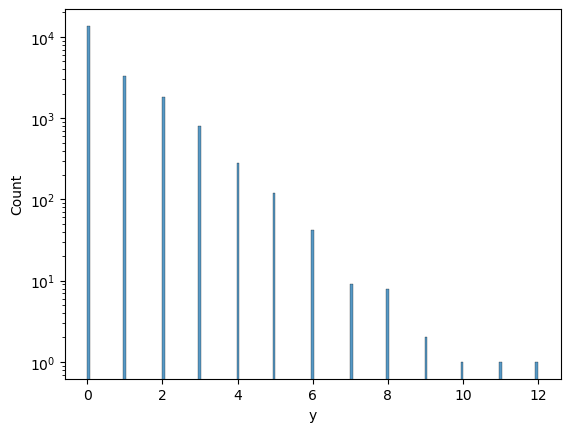

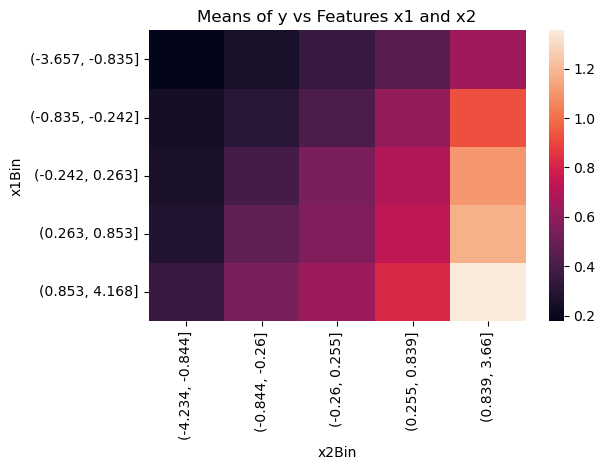

In [9]:
alpha, beta = (.5, .5)
df = generate_data((alpha, beta), 20000)
plot_generated_data(df)

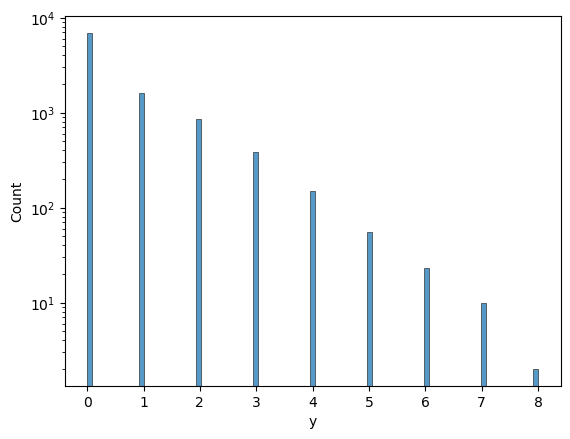

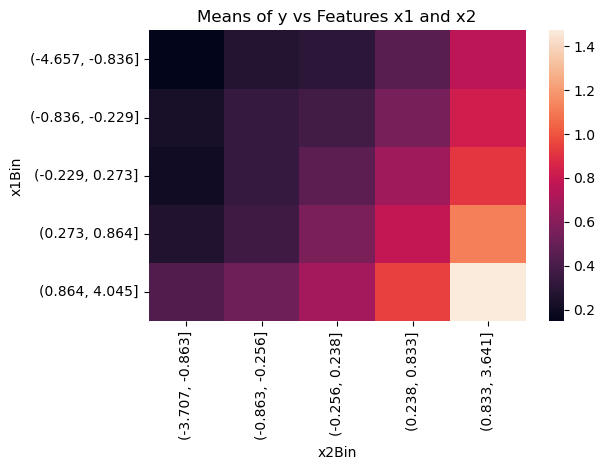

In [10]:
alpha, beta = (.5, .5)
df = generate_data((alpha, beta), 10000)
plot_generated_data(df)

In [11]:
df.head()

,x1,x2,y
0,-0.562354,0.035319,0
1,-1.015290,-1.011656,0
2,-0.019450,-0.749060,1
3,0.774465,0.357139,0
4,-0.444768,0.097306,1


In [12]:
train = torch.tensor(df.values, dtype=torch.float)
y, x1, x2 = train[:, 2], train[:, 0], train[:, 1]

In [13]:
# y

In [14]:
# x1

In [15]:
# x2

In [16]:
# y

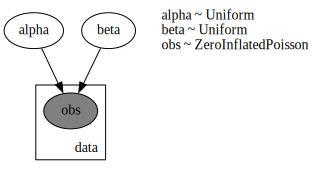

In [17]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(x1, x2, y = None):

    alpha = pyro.sample("alpha", dist.Uniform(-1, 1))
    beta = pyro.sample("beta", dist.Uniform(-1, 1))

    gate = 1 - torch.sigmoid(torch.mul(alpha, x1))
    rate = torch.exp(torch.mul(beta, x2))

    # iszero = pyro.sample("iszero", dist.Bernoulli(gate))
    # ywithoutzero = pyro.sample("ywithoutzero", dist.Poisson(rate))

    with pyro.plate("data", len(x2)):
               
        # return torch.mul(iszero, ywithoutzero)
        
        return pyro.sample("obs", dist.ZeroInflatedPoisson(gate = gate, rate = rate), obs=y)

pyro.render_model(simple_model, model_args=(x1, x2, y), render_distributions=True, render_params=True)

In [18]:
simple_model

<function __main__.simple_model(x1, x2, y=None)>

Elbo loss: 10006.783856868744
Elbo loss: 10039.363672614098
Elbo loss: 9843.613380432129
Elbo loss: 9813.149097561836
Elbo loss: 9759.73662340641
Elbo loss: 9634.610817790031
Elbo loss: 9615.31327176094
Elbo loss: 9531.173090457916
Elbo loss: 9545.29773068428
Elbo loss: 9466.497952103615
Elbo loss: 9524.379136919975
Elbo loss: 9454.920417428017
Elbo loss: 9435.121943831444
Elbo loss: 9417.01498579979
Elbo loss: 9402.20408129692
Elbo loss: 9389.106863856316
Elbo loss: 9393.635924696922
Elbo loss: 9388.284960985184
Elbo loss: 9409.576219201088
Elbo loss: 9384.997600913048
Elbo loss: 9393.875494360924
Elbo loss: 9387.28298342228
Elbo loss: 9385.642463445663
Elbo loss: 9391.934391260147
Elbo loss: 9386.906590461731
Elbo loss: 9389.379822134972
Elbo loss: 9395.840381741524
Elbo loss: 9391.677606344223
Elbo loss: 9387.037005782127
Elbo loss: 9385.245393395424


CPU times: user 1min 45s, sys: 1.1 s, total: 1min 46s
Wall time: 10.6 s


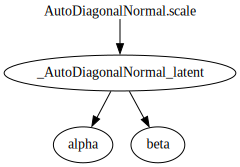

In [19]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoDiagonalNormal(simple_model)
adam = pyro.optim.Adam({"lr": 0.001})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(simple_model, auto_guide, adam, elbo)

losses = []
for step in range(3000):  # Consider running for more steps.
    loss = svi.step(x1, x2, y)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

pyro.render_model(auto_guide, model_args=(x1, x2, y), render_params=True)

Text(0, 0.5, 'ELBO loss')

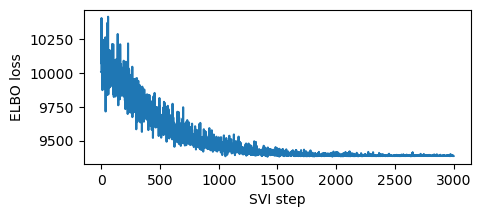

In [20]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

In [21]:
for name, value in pyro.get_param_store().items():
    print(name, (pyro.param(name).data.cpu().numpy()))
    # print(name, pyro.param(name).item())

AutoDiagonalNormal.loc [1.2664583 1.1408383]
AutoDiagonalNormal.scale [0.09079358 0.07424292]


In [22]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(x1, x2)

In [23]:
print("alpha mean: ", samples['alpha'].mean().item())
print("alpha std: ", samples['alpha'].std().item())
print("beta mean: ", samples['beta'].mean().item())
print("beta std: ", samples['beta'].std().item())

alpha mean:  0.5606123208999634
alpha std:  0.0325169637799263
beta mean:  0.5152836441993713
beta std:  0.027585914358496666


(array([  2.,   4.,   7.,  14.,  23.,  33.,  52.,  84.,  84., 108.,  85.,
         96.,  74.,  61.,  39.,  20.,   7.,   3.,   3.,   1.]),
 array([0.45697963, 0.46743447, 0.4778893 , 0.48834416, 0.498799  ,
        0.50925386, 0.51970869, 0.53016353, 0.54061836, 0.55107319,
        0.56152803, 0.57198286, 0.58243769, 0.59289253, 0.60334736,
        0.61380219, 0.62425709, 0.63471192, 0.64516675, 0.65562159,
        0.66607642]),
 <BarContainer object of 20 artists>)

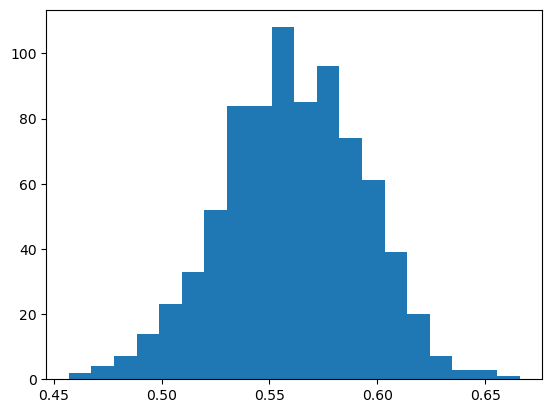

In [25]:
plt.hist(samples['alpha'].detach().numpy(), bins=20)

(array([ 4.,  4., 11., 22., 25., 42., 46., 64., 81., 68., 76., 69., 82.,
        61., 57., 24., 33., 16.,  9.,  6.]),
 array([0.44005716, 0.44729164, 0.45452613, 0.46176061, 0.46899509,
        0.47622958, 0.48346406, 0.49069855, 0.49793303, 0.50516748,
        0.512402  , 0.51963651, 0.52687097, 0.53410542, 0.54133993,
        0.54857445, 0.5558089 , 0.56304336, 0.57027787, 0.57751238,
        0.58474684]),
 <BarContainer object of 20 artists>)

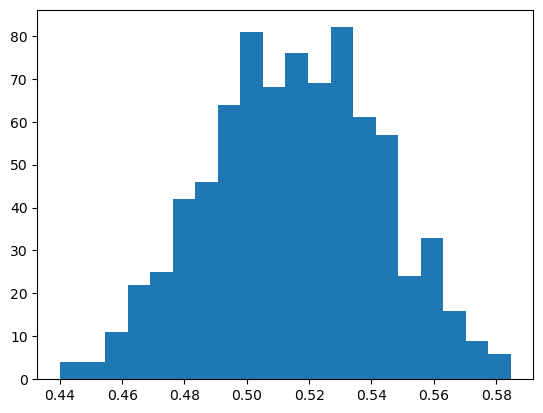

In [26]:
plt.hist(samples['beta'].detach().numpy(), bins=20)

In [27]:
predictive = pyro.infer.Predictive(simple_model, guide=auto_guide, num_samples=800)
svi_samples = predictive(x1, x2)
svi_y = svi_samples["obs"]

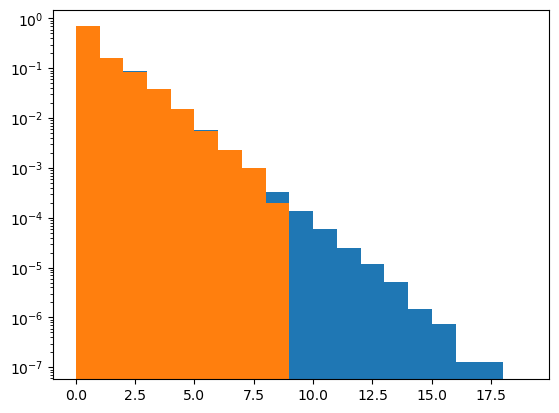

In [28]:
plt.hist(svi_samples["obs"].detach().numpy().flatten(), bins=range(20), density = True)
plt.yscale('log')
plt.hist(y.detach().numpy().flatten(), bins=range(20), density = True)
plt.yscale('log')


In [29]:
predictions = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y_mean": svi_y.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_y": y,
})

predictions.head()

,x1,x2,y_mean,y_perc_5,y_perc_95,true_y
0,-0.562354,0.035319,0.51000,0.0,2.0,0.0
1,-1.015290,-1.011656,0.21500,0.0,1.0,0.0
2,-0.019450,-0.749060,0.42750,0.0,2.0,1.0
3,0.774465,0.357139,0.78000,0.0,3.0,0.0
4,-0.444768,0.097306,0.44375,0.0,2.0,1.0


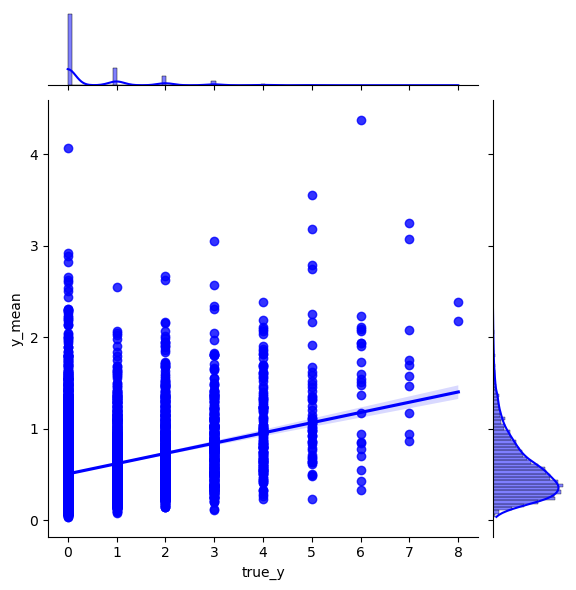

In [30]:
sns.jointplot(x="true_y", y="y_mean", data=predictions, kind="reg", color="b")